In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV,KFold
import warnings

# Désactiver tous les avertissements
warnings.filterwarnings('ignore')

# Ou désactiver uniquement les avertissements de type FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)


In [22]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [23]:


features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','RevLineCr','Term','ApprovalFY','crisis',
    'MIS_Status'
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [25]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [26]:


clf = make_pipeline(preprocessor,lgb.LGBMClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
clf.fit(X_train, y_train_encoded)

[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 674
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [27]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9778519921609818
accuracy 0.9478407865031084
rappel 0.8154226333797998
f1_score 0.845865650059156
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



In [28]:
#Dataframe pour les features of importances

df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__RevLineCr_Y', 'categorical__RevLineCr_`',
       'categorical__RevLineCr_nan', 'ordinal__LowDoc',
       'numeric__bank_loan_float', 'numeric__SBA_loan_float', 'numeric__Term',
       'remainder__UrbanRural', 'remainder__ApprovalFY', 'remainder__crisis'],
      dtype='object', length=2833)

In [29]:
# Création des sommes pour les features importances pour chaque variable catégorielle


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)
    


['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_crisis', 'sum_MIS_Status']


In [30]:
# Création des sommes pour les features importances pour chaque variables


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)

['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_crisis', 'sum_MIS_Status']


In [31]:
df_rf_graphique = df_rf[liste_sum]

In [32]:
df_rf_graphique


,sum_State,sum_cat_activites,sum_UrbanRural,sum_LowDoc,sum_bank_loan_float,sum_SBA_loan_float,sum_FranchiseCode,sum_BankState,sum_RevLineCr,sum_Term,sum_ApprovalFY,sum_crisis,sum_MIS_Status
0,1798,200,44,52,210,326,106,932,374,2644,686,26,0


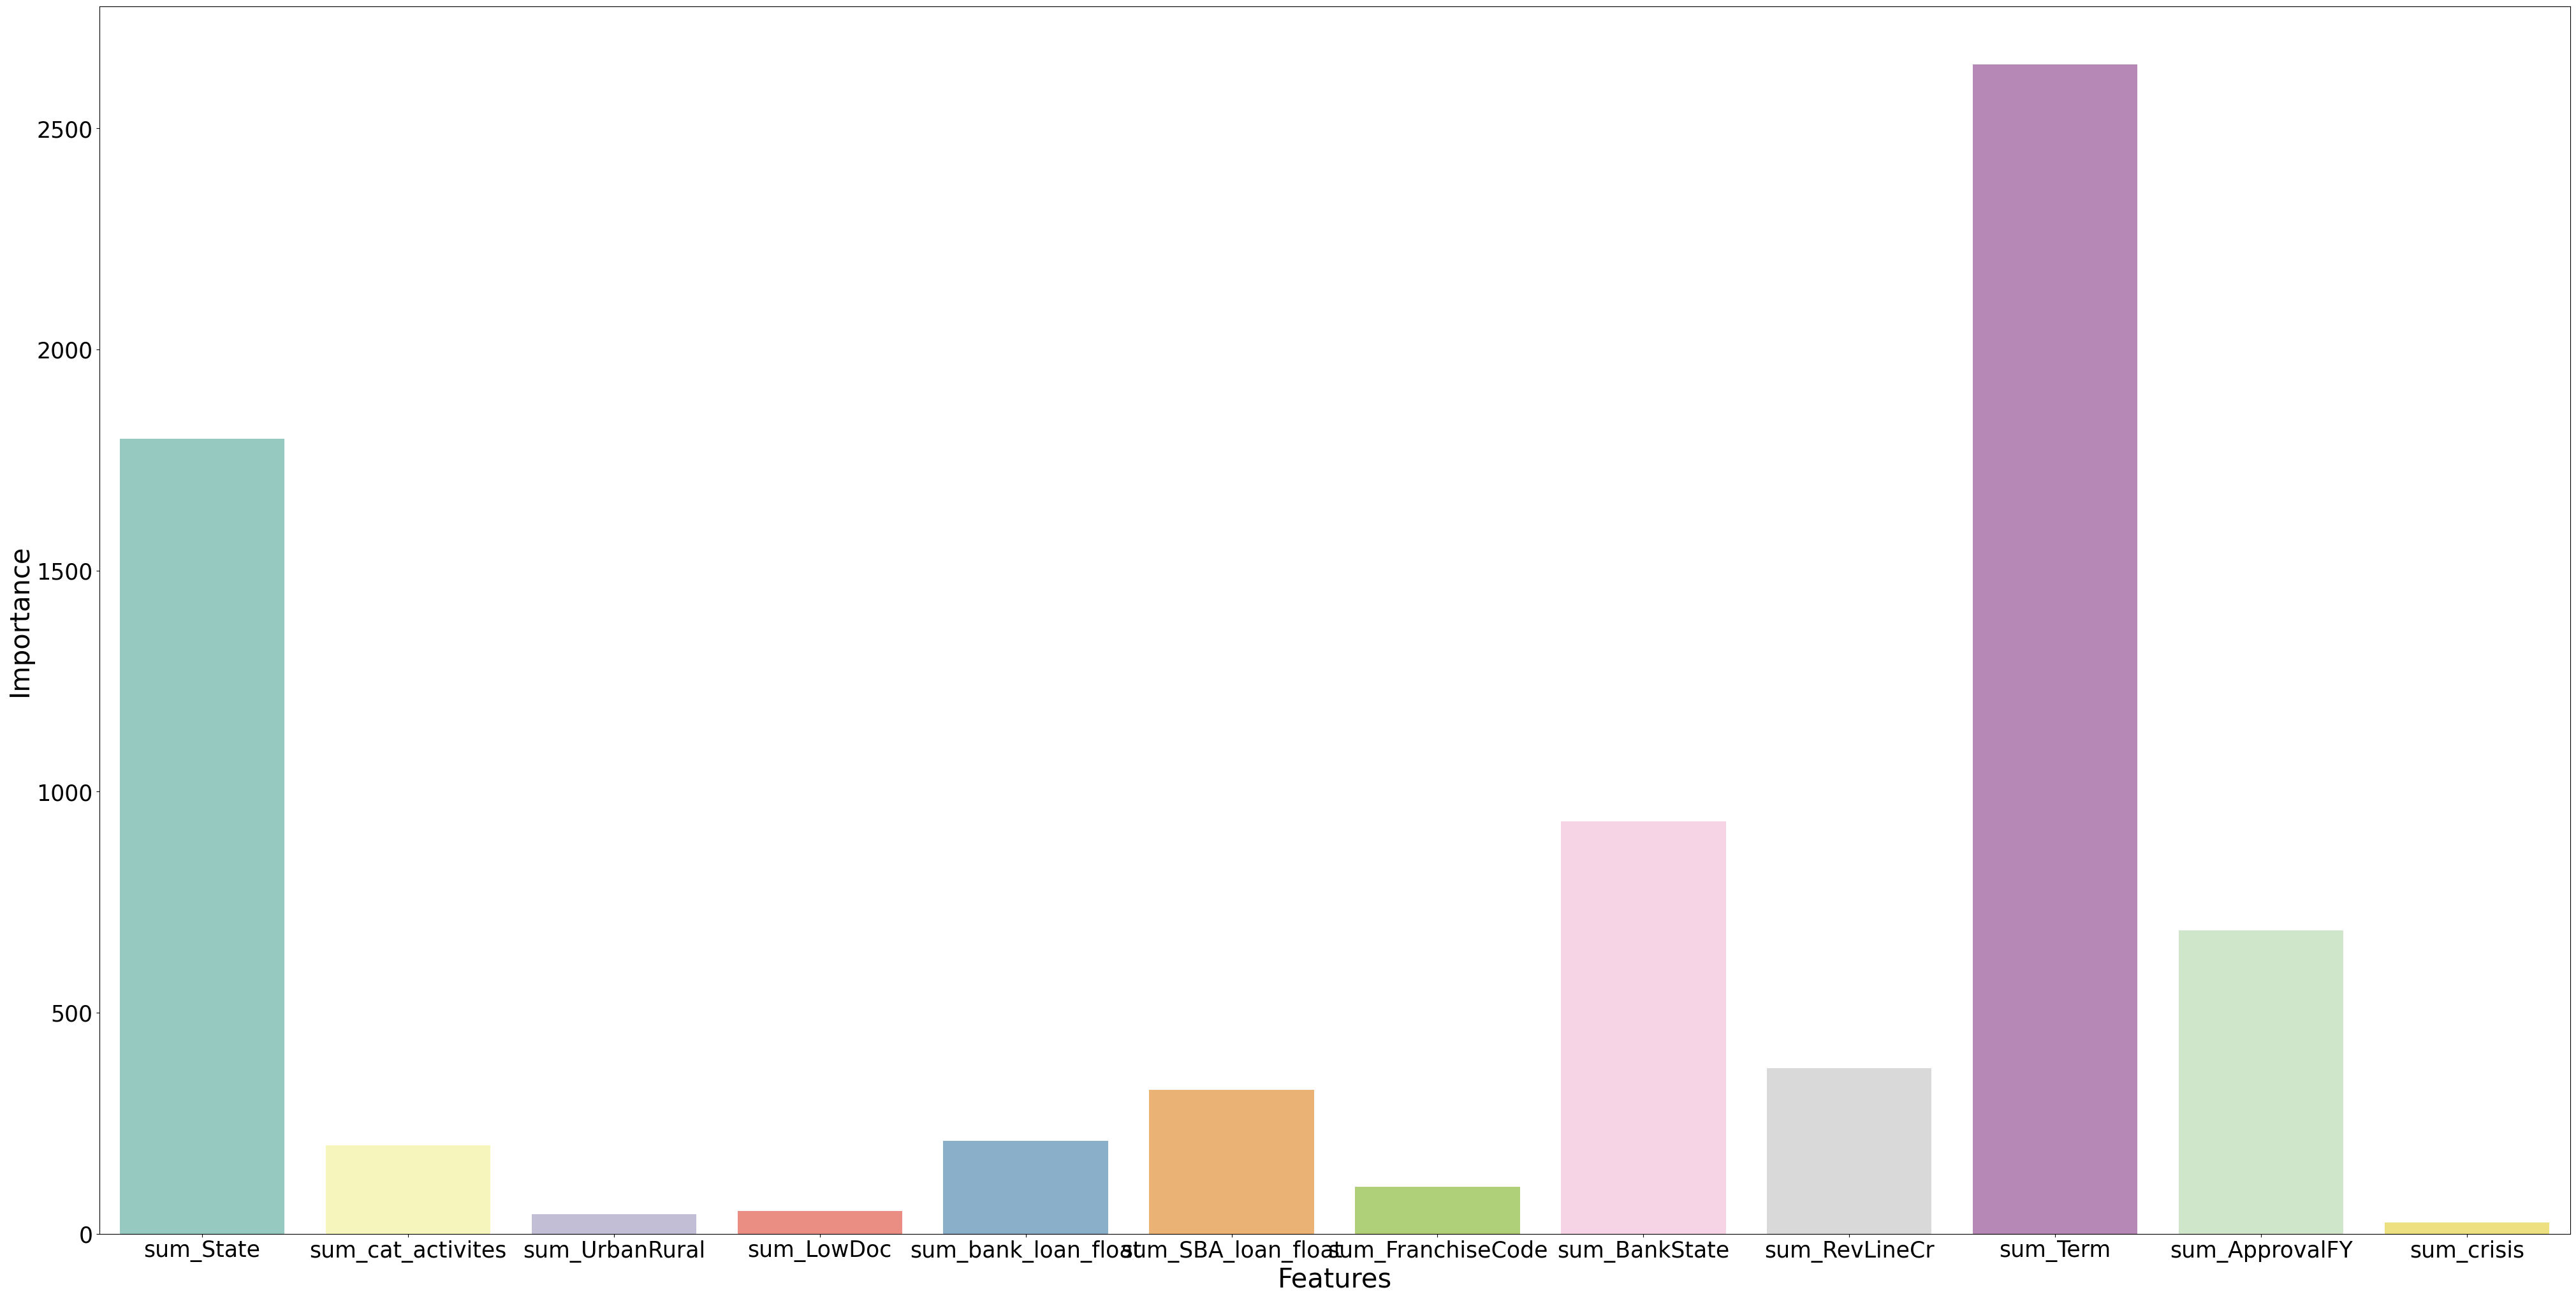

In [33]:


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [34]:
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [35]:
# import pickle
# pickle.dump(clf,open('clf_lgbm.pkl','wb'))
X_train

,State,cat_activites,UrbanRural,LowDoc,bank_loan_float,SBA_loan_float,FranchiseCode,BankState,RevLineCr,Term,ApprovalFY,crisis
769904,IL,45,0,Y,100000.0,90000.0,36560,IL,NaN,60,1995,0
653567,DC,56,0,N,5000.0,4250.0,1,CA,0,1,2003,0
426296,CA,23,1,N,400000.0,300000.0,1,CA,N,120,2001,1
330866,NY,54,1,N,10000.0,5000.0,0,NY,Y,36,2009,0
745739,CA,31,0,N,300000.0,210000.0,1,CA,N,84,1995,0
...,...,...,...,...,...,...,...,...,...,...,...,...
827911,OH,42,2,N,75000.0,37500.0,1,OH,Y,84,2005,0
248832,NY,44,1,N,70000.0,35000.0,0,NY,Y,8,2008,1
730785,IN,54,0,Y,50000.0,45000.0,1,IN,N,84,1994,0
480600,IN,44,0,N,145000.0,145000.0,1,IN,N,240,1992,0


In [36]:
np.random.seed(1)

train = X_train
test = X_test
# Si y_train_encoded et y_test_encoded sont des numpy.ndarray, les convertir en pandas.Series
y_train_encoded_series = pd.Series(y_train_encoded)
y_test_encoded_series = pd.Series(y_test_encoded)

y = y_train_encoded
print(train.shape, test.shape, y.shape)



gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=y)

param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=categorical_column)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=train, y=y)

print(lgb_model.best_params_, lgb_model.best_score_)

(809247, 12) (89917, 12) (809247,)


ValueError: 
All the 600 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/engine.py", line 282, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 3637, in __init__
    train_set.construct()
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 2576, in construct
    self._lazy_init(
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 2106, in _lazy_init
    data, feature_name, categorical_feature, self.pandas_categorical = _data_from_pandas(
                                                                       ^^^^^^^^^^^^^^^^^^
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 848, in _data_from_pandas
    _pandas_to_numpy(data, target_dtype=target_dtype),
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 794, in _pandas_to_numpy
    _check_for_bad_pandas_dtypes(data.dtypes)
  File "/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/basic.py", line 784, in _check_for_bad_pandas_dtypes
    raise ValueError(
ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: State: object, LowDoc: object, BankState: object, RevLineCr: object


In [35]:
train = X_train
test = X_test
# Si y_train_encoded et y_test_encoded sont des numpy.ndarray, les convertir en pandas.Series
y_train_encoded_series = pd.Series(y_train_encoded)
y_test_encoded_series = pd.Series(y_test_encoded)

y = y_train_encoded
print(train.shape, test.shape, y.shape)


preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)


# Définir le modèle LGBMClassifier avec un pipeline
lgb_estimator = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=2000,
    learning_rate=0.01,
    metric='auc'
)

# Créer un pipeline qui applique le préprocesseur et entraîne le modèle
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgb_estimator)])


# Utilisation de KFold pour la validation croisée
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=y)


# Définir la grille de paramètres à tester dans GridSearchCV
param_grid = {
    'classifier__num_leaves': [31, 127],
    'classifier__reg_alpha': [0.1, 0.5],
    'classifier__min_data_in_leaf': [30, 50, 100, 300, 400],
    'classifier__lambda_l1': [0, 1, 1.5],
    'classifier__lambda_l2': [0, 1]
}

# Effectuer la recherche par grille
gsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=gkf)

# Entraîner le modèle avec la recherche par grille
lgb_model = gsearch.fit(X=train, y=y)

# Afficher les meilleurs paramètres et le meilleur score
print(lgb_model.best_params_, lgb_model.best_score_)

(809247, 12) (89917, 12) (809247,)
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 533861, number of negative: 113536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.361897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

KeyboardInterrupt: 